In [1]:
using Pkg
# This is a numerical integration package that we use for cosmology distances
Pkg.add("QuadGK")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %Fetching: [============>                            ]  28.1 %Fetching: [=================>                       ]  40.7 %>                  ]  54.4 %>           ]  70.8 %Fetching: [=================================>       ]  82.1 %> ]  95.8 % Resolving package versions...
 Installed DiffEqDiffTools ── v0.7.1
 Installed SpecialFunctions ─ v0.7.2
 Installed IntervalSets ───── v0.3.1
 Installed Plots ──────────── v0.21.0
 Installed StaticArrays ───── v0.9.2
 Installed ForwardDiff ────── v0.10.1
 Installed Nemo ───────────── v0.10.3
 Installed ImageView ──────── v0.8.1
 Installed MbedTLS ────────── v0.6.5
 Installed Colors ─────────── v0.9.5
 Installed GR ─────────────── v0.35.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [86fae568] ↑ ImageView v0.8.0 ⇒ v0.8.1
  [2edaba10] ↑ Nemo v0.10.2 ⇒ v0.

In [75]:
# For Flat Lambda CDM, the distances should be computable using a "special" function
# hyp2f1 which is in scipy but I couldn't find in Julia other than in the "Nemo" package,
# but I couldn't get that working, so below I'm just using the integral version.
#Pkg.add("Nemo")

In [2]:
using QuadGK
#using Nemo
using Plots
using Statistics

┌ Info: Recompiling stale cache file /Users/dstn/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


This is a cheap function to read in the data table.

In [3]:
function read_data()
    open("p99-data.txt", "r") do io
        line = readline(io)
        # drop "#"
        if line[1] == '#'
            line = line[2:end]
        end
        words = split(line)
        # println(words)
        ncols = length(words)
        lines = readlines(io)
        nlines = length(lines)
        #println("Read ", nlines, " lines")
        names = []
        redshift = zeros(nlines)
        m_b_eff = zeros(nlines)
        sigma_m_b_eff = zeros(nlines)
        for i in 1:nlines
            #println("Line: ", lines[i])
            # HACK --- I'm hard-coding which columns contain which data
            words = split(lines[i])
            push!(names, words[1])
            redshift[i] = parse(Float64, words[2])
            m_b_eff[i] = parse(Float64, words[9])
            sigma_m_b_eff[i] = parse(Float64, words[10])
        end
        return names, redshift, m_b_eff, sigma_m_b_eff
    end
end;

In [4]:
(name, z, m, merr) = read_data();

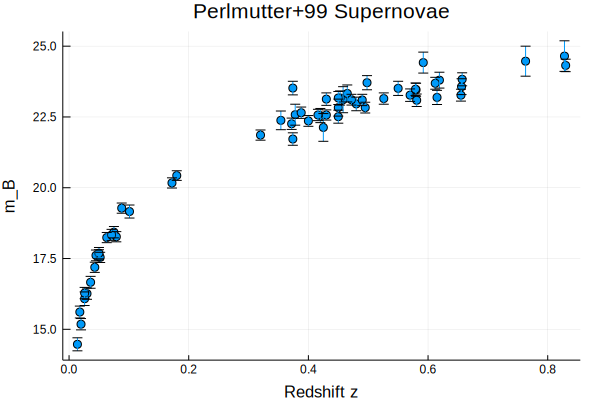

In [5]:
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")

Distance functions for a Flat Lambda CDM cosmology model.

In [6]:
# These functions are taken from astropy.cosmology, specialized for
# the FlatLambdaCDM model.
#

# A minimal Flat Lambda CDM model
mutable struct LCDM
    Om0::Float64
    Ode0::Float64
    hubble_distance::Float64
end

#
function luminosity_distance(cosmology, z)
    return (1. + z) * comoving_transverse_distance(cosmology, z)
end
function comoving_transverse_distance(cosmology, z)
    return comoving_transverse_distance_z1z2(cosmology, 0., z)
end
function comoving_transverse_distance_z1z2(cosmology, z1, z2)
    # HERE we're assuming Ok0=0
    # (Omega curvature; the effective curvature density/critical density at z=0)
    return comoving_distance_z1z2(cosmology, z1, z2)
end

function comoving_distance_z1z2(cosmology, z1, z2)
    #hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    integral_comoving_distance_z1z2(cosmology, z1, z2)
end

function integral_comoving_distance_z1z2(cosmology, z1, z2)
    function flcdm_inv_efunc_norel(z)
        Om0 = cosmology.Om0
        Ode0 = cosmology.Ode0
        return ((1. + z)^3 * Om0 + Ode0) ^ -0.5
    end
    # HERE we turn off relativistic species (Tcmb=0)
    (integral,error) = quadgk(flcdm_inv_efunc_norel, z1, z2)
    return cosmology.hubble_distance * integral
end

function hypergeometric_comoving_distance_z1z2(cosmology, z1, z2)
    # def _hypergeometric_comoving_distance_z1z2(self, z1, z2):
    s = ((1 - cosmology.Om0) / cosmology.Om0) ^ (1. / 3)
    # Use np.sqrt here to handle negative s (Om0>1).
    prefactor = cosmology.hubble_distance / sqrt(s * cosmology.Om0)
    return prefactor * (T_hypergeometric(s / (1 + z1)) -
                        T_hypergeometric(s / (1 + z2)))
end
function T_hypergeometric(x)
    #from scipy.special import hyp2f1
    return 2 * sqrt(x) * Nemo.hyp2f1(1. / 6, 1. / 2, 7. / 6, -x^3)
end;

In [7]:
universe = LCDM(0.25, 0.75, 60.)

LCDM(0.25, 0.75, 60.0)

In [8]:
luminosity_distance(universe, 0.1)

6.472917483161313

In [9]:
# Perlmutter+ define D_L = H_0 d_L; you could drop the factor of hubble_distance
# from luminosity_distance here if you wanted.  It will all just get folded into the
# M_B offset.
function distance_modulus(universe, z)
    5. * log10.(luminosity_distance(universe, z) / 10.)
end;

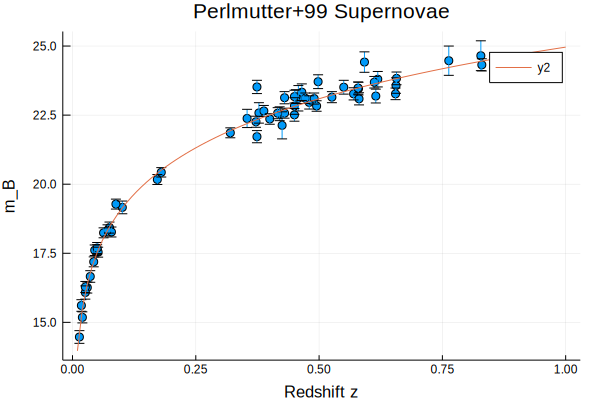

In [10]:
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")
zgrid = 0.01:0.01:1.
DL = map(z->distance_modulus(universe, z), zgrid)

DLx = map(z->distance_modulus(universe, z), z)
offset = median(m - DLx)
plot!(zgrid, DL .+ offset)
